# I. Introduction

## B. Energy Data Retrieval

**0. Installing Dependencies**

In [8]:
#Dependencies
%pip install openpyxl matplotlib pandas darts statsmodels dash -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
file_paths = [
    '../../Data/EnergieUebersichtCH-2022.xlsx',
    '../../Data/EnergieUebersichtCH-2023.xlsx',
    '../../Data/EnergieUebersichtCH-2024.xlsx',
    '../../Data/EnergieUebersichtCH-2025.xlsx',
]
sheet_name = 'Zeitreihen0h15'
total = 29000

**1.1 Retrieving Energy Data**

In [10]:
import pandas as pd

In [11]:
if 'dfs_loaded' not in globals():
    dfs = []
    for path in file_paths:
        xls = pd.ExcelFile(path)
        df_year = pd.read_excel(xls, sheet_name=sheet_name, header=1)
        dfs.append(df_year)
    dfs_loaded = True 


**1.2 Combining all years into a single DataFrame and rename columns**

In [12]:
df = pd.concat(dfs, ignore_index=True)
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

## C. Weather Data Retrieval

In [13]:
import cdsapi
c = cdsapi.Client()
lat_min = 45.8
lat_max = 48.5
lon_min = 5.9
lon_max = 10.5
import xarray as xr

# Open GRIB file using cfgrib engine
import xarray as xr
import pandas as pd
if 'weather_loaded' not in globals():
    # Load and subset Switzerland region
    ds_before_2025 = xr.open_dataset("../../Data/Weather/Seasonal forecast anomalies on single levels.grib", engine="cfgrib")

    # Load 2025 dataset
    ds_2025 = xr.open_dataset("../../Data/Weather/Seasonal forecast anomalies on single levels  2025.grib", engine="cfgrib")

# Combine along the time dimension
    ds = xr.concat([ds_before_2025, ds_2025], dim="time")
    swiss = ds['t2a'].sel(
        latitude=slice(48.5, 45.8),
        longitude=slice(5.9, 10.5)
    )
    weather_loaded = True

# Average over lat/lon and ensemble members → monthly anomalies
monthly_avg = swiss.mean(dim=['latitude', 'longitude', 'number'])

# Further average over lead time steps (optional: or pick just step=0)
monthly_mean = monthly_avg.mean(dim='step')

# Create weekly date range covering the same period
start_date = pd.to_datetime(monthly_mean.time.values[0])
end_date = pd.to_datetime(monthly_mean.time.values[-1]) + pd.DateOffset(months=1)  # buffer

# Generate weekly dates (every Monday)
weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Interpolate from monthly to weekly using xarray
weekly_interp = monthly_mean.interp(time=weekly_dates)

# convert to pandas
weekly_temp_anomaly = weekly_interp.to_series()

# Preview
print(weekly_temp_anomaly.head(2))


time
2021-01-04    0.264809
2021-01-11    0.342694
Name: t2a, dtype: float64


## D. Data Cleaning

Checking for missing values

In [14]:
import plotly.express as px

df.loc[df['Total Energy Consumption (kWh)'].isna(), 'color'] = 'Total Energy Consumption'

# Mask for rows with any NA values
mask = df.isna().any(axis=1)
df_missing = df[mask].copy()
df_missing['is_missing'] = True  # optional for consistent y-axis

print(df_missing.head())


Empty DataFrame
Columns: [Zeitstempel, Total Energy Consumed by End Users (kWh), Total Energy Production (kWh), Total Energy Consumption (kWh), Net Outflow (kWh), Grid Feed-In (kWh), Positive Secondary Control Energy (kWh), Negative Secondary Control Energy (kWh), Positive Tertiary Control Energy (kWh), Negative Tertiary Control Energy (kWh), kWh.9, kWh.10, kWh.11, kWh.12, kWh.13, kWh.14, kWh.15, kWh.16, kWh.17, kWh.18, kWh.19, Euro/MWh, Euro/MWh.1, Euro/MWh.2, Euro/MWh.3, kWh.20, kWh.21, kWh.22, kWh.23, kWh.24, kWh.25, kWh.26, kWh.27, kWh.28, kWh.29, kWh.30, kWh.31, kWh.32, kWh.33, kWh.34, kWh.35, kWh.36, kWh.37, kWh.38, kWh.39, kWh.40, kWh.41, kWh.42, kWh.43, kWh.44, kWh.45, kWh.46, kWh.47, kWh.48, kWh.49, kWh.50, kWh.51, kWh.52, kWh.53, kWh.54, kWh.55, kWh.56, kWh.57, kWh.58, kWh.59, color, is_missing]
Index: []

[0 rows x 67 columns]


Is each index unique?

In [15]:
df.index.is_unique

True

Check min, max, std for anomalies

In [16]:
print(df['Total Energy Consumption (kWh)'].describe()[1:9]) 

mean    1.803166e+06
std     2.656051e+05
min     1.038507e+06
25%     1.626075e+06
50%     1.808781e+06
75%     1.983396e+06
max     2.603810e+06
Name: Total Energy Consumption (kWh), dtype: float64


## E. Data Aggregation

1.1 Aggregate Data by week, starting Monday

In [17]:
df['Zeitstempel'] = pd.to_datetime(
    df['Zeitstempel'],
    format='%d.%m.%Y %H:%M',   
    dayfirst=True,            
    errors='raise'            
)


In [18]:
df = df.set_index('Zeitstempel')
df = df.resample('W-Mon').sum()
df = df[1:-1]

In [19]:
total = int ((total / 96) -1) 
print(total)

301


In [20]:
time_index = df.index

Save backup 

In [21]:
df_backup = df

**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [22]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

The goal is to predict the next element of the Total Energy Consumption columb:

In [23]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].values

In [24]:
import matplotlib.pyplot as plt

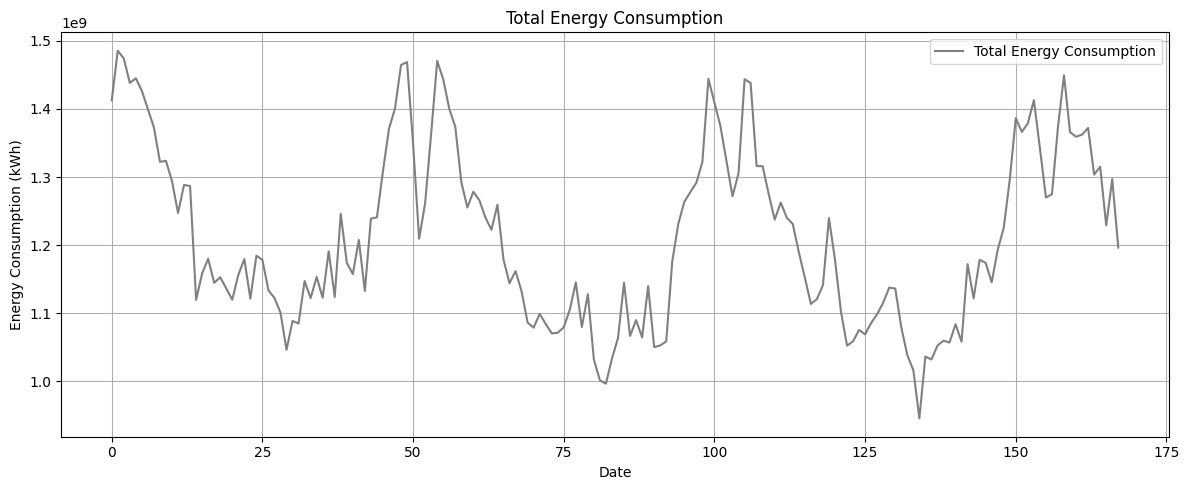

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(energy_consumption_data, label='Total Energy Consumption', color='gray')
ax.set_title('Total Energy Consumption')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# III: Time Series Analysis 

**III. 1. Stationarity of my Time Series**

## A. Mean Calculation

Calculating the mean of my time series (Total Power Consumption in the Grid)

the formula for the mean is: μ = (x₁ + x₂ + ... + xₙ) / n

In [26]:
def mean(data):
    return sum(data) / len(data)

In [27]:
print(mean(energy_consumption_data))

1211709601.3882809


In [28]:
def sliced_mean_calculator(data, time_index,variance_window_size):
    means = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = mean(window_slice)
        means.append(var)
        time_indices.append(time_index[i + variance_window_size - 1])
    return means, time_indices

In [29]:
mean_window_size = len(energy_consumption_data) // 10

In [30]:
means, time_indices = sliced_mean_calculator(energy_consumption_data,time_index, mean_window_size)

Plotting Mean over time

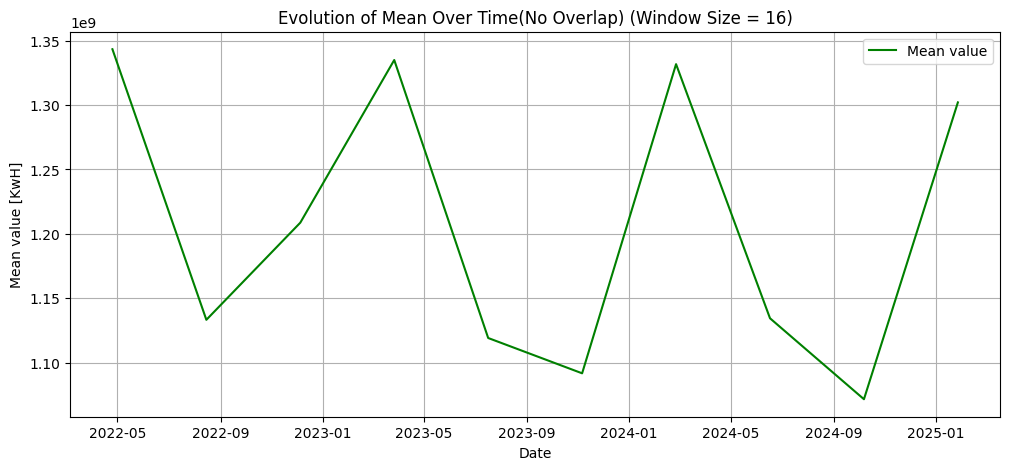

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, means, color='green', label='Mean value')
plt.xlabel('Date')
plt.ylabel('Mean value [KwH]')
plt.title(f'Evolution of Mean Over Time(No Overlap) (Window Size = {mean_window_size})')
plt.grid(True)
plt.legend()
plt.show()

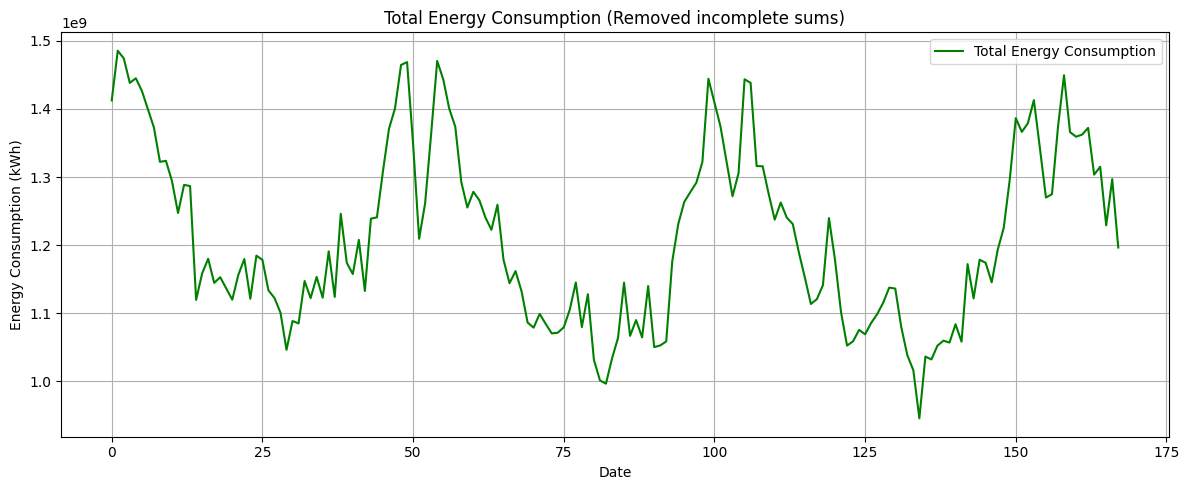

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(energy_consumption_data, label='Total Energy Consumption', color='green')
ax.set_title('Total Energy Consumption (Removed incomplete sums)')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## B. Variance Calculation

Calculating Variance:

Variance = 1/n sum(xi- mean)**2

In [33]:
def variance(data):
    mean_value = mean(data)
    variance = sum((x - mean_value)**2 for x in data) / len(data)
    return variance
print(variance(energy_consumption_data))

1.6370991923612188e+16


Plotting variance over time

16
[1.0960480879829592e+16, 1464521258618045.5, 7200982635238046.0, 8155543075894944.0, 2430623248220715.5, 5744999445593979.0, 4415194650633357.5, 3907984911992913.0, 2938256858112266.0, 8608203570732048.0] [Timestamp('2022-04-25 00:00:00'), Timestamp('2022-08-15 00:00:00'), Timestamp('2022-12-05 00:00:00'), Timestamp('2023-03-27 00:00:00'), Timestamp('2023-07-17 00:00:00'), Timestamp('2023-11-06 00:00:00'), Timestamp('2024-02-26 00:00:00'), Timestamp('2024-06-17 00:00:00'), Timestamp('2024-10-07 00:00:00'), Timestamp('2025-01-27 00:00:00')]


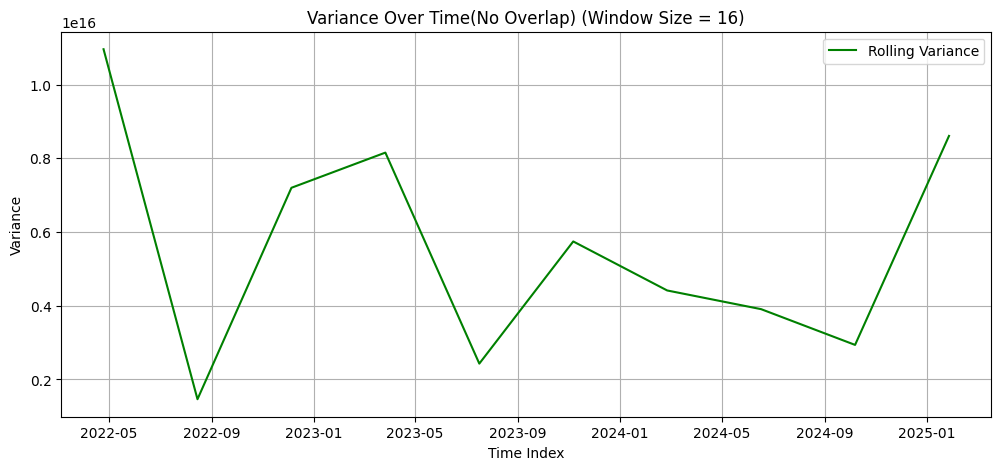

In [34]:
total_length =  len(energy_consumption_data)
variance_window_size = total_length // 10
print(variance_window_size)
def sliced_variances_calculator(data, time_index,variance_window_size):
    variances = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = variance(window_slice)
        variances.append(var)
        time_indices.append(time_index[i + variance_window_size - 1]) 
    return variances, time_indices

variances, time_indices = sliced_variances_calculator(energy_consumption_data,time_index, variance_window_size)
print(variances, time_indices)
#Plotting the variances
plt.figure(figsize=(12, 5))
plt.plot(time_indices, variances, color='green', label='Rolling Variance')
plt.xlabel('Time Index')
plt.ylabel('Variance')
plt.title(f'Variance Over Time(No Overlap) (Window Size = {variance_window_size})')
plt.grid(True)
plt.legend()
plt.show()

## C. Autocorrelation Calculation

In [35]:
from statsmodels.tsa.stattools import acf
import numpy as np

autocorrelation function (ACF) at lag k, for k ≥ 0, of the time series is defined by
ro k = ck/ c0 where ck is the autocovariance at lag k

In [36]:
alpha = 0.05
confint = 1 - alpha
nlags = 160
def check_autocorrelation(data, nlags=10, alpha=0.05):
    data = np.asarray(data)
    acf_vals, _ = acf(data, nlags=nlags, alpha=alpha) 
    return acf_vals

acf_vals = check_autocorrelation(energy_consumption_data, nlags=nlags)
print(f"High Autocorrelation defined as {1 - alpha}")
for lag in range(1, 5):
    print(f"lag {lag:2d} → ACF = {acf_vals[lag]: .4f}")

High Autocorrelation defined as 0.95
lag  1 → ACF =  0.9028
lag  2 → ACF =  0.8092
lag  3 → ACF =  0.7166
lag  4 → ACF =  0.6537


Setting axis at 0

In [37]:
from darts import TimeSeries

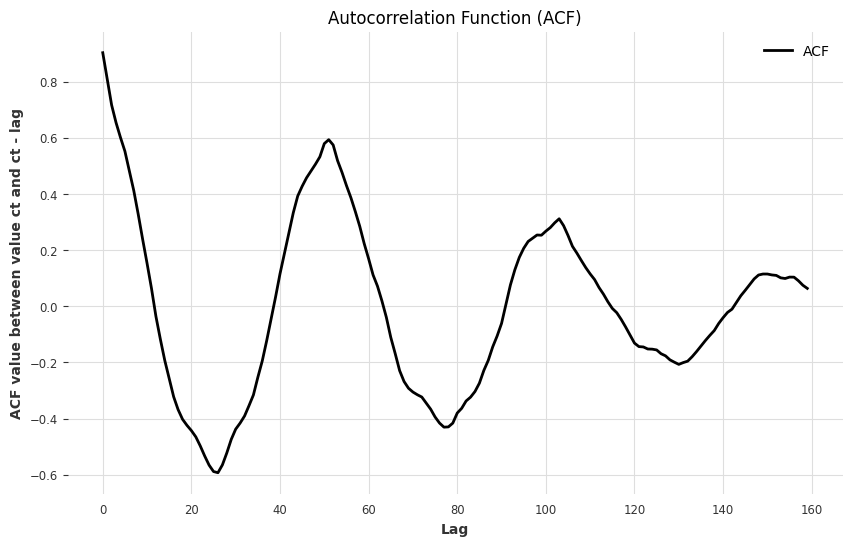

In [38]:
acf_series = TimeSeries.from_values(acf_vals[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF value between value ct and ct - lag")
plt.legend(loc="upper right")
plt.show()

<Figure size 1000x600 with 0 Axes>

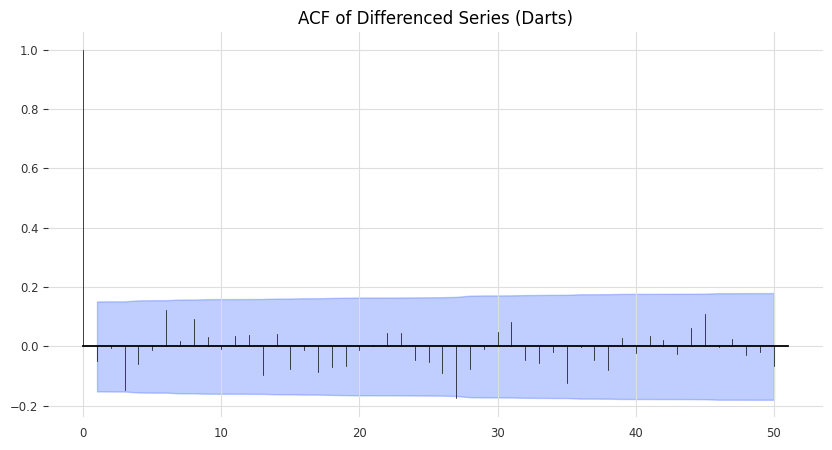

In [39]:
from darts import TimeSeries
from darts.utils.statistics import plot_acf 
import matplotlib.pyplot as plt

# --- Convert to TimeSeries and compute first difference ---
series = TimeSeries.from_values(energy_consumption_data)
diff_series = series.diff()

plt.figure(figsize=(10, 6))
plot_acf(diff_series, max_lag=50, alpha=0.05)
plt.title("ACF of Differenced Series (Darts)")
plt.show()

After calculating the autocovariance vector, I'm going to use Yule-Walker Modified Method to calculate the PACF vector

This is given by the formula R . ϕ = r where R is the Yule-Walker matrix , r is the ACF vector, ϕ is the PACF vector we're looking for

In [40]:
from scipy.linalg import toeplitz

In [41]:
def pacf_yule_walker_full(gamma: np.ndarray, nlags: int):
    pacf_vals = []
    for k in range(1, nlags + 1):
        R = toeplitz(gamma[:k])          
        r = gamma[1:k+1]                 # r_k: γ(1) to γ(k)
        phi = solve(R, r)                # Solving for R * phi = r
        pacf_vals.append(phi[-1])      
    return np.array(pacf_vals)
from numpy.linalg import solve

In [42]:
from darts.utils.statistics import (
    plot_acf,
)

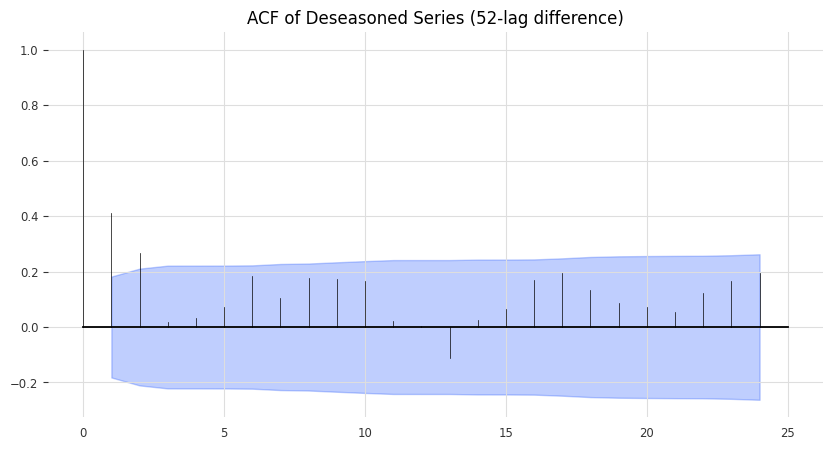

In [43]:
# Get the deseasoned or differenced values as flat array
deseasoned_vals = df['Total Energy Consumption (kWh)'].diff(52).dropna().values

# Now plot ACF
plot_acf(TimeSeries.from_values(deseasoned_vals))
plt.title("ACF of Deseasoned Series (52-lag difference)")
plt.show()


# B. Differencing

Differencing is a simple approach to removing trends. No need to estimate parameters.

Dt = yt - y(t-1)

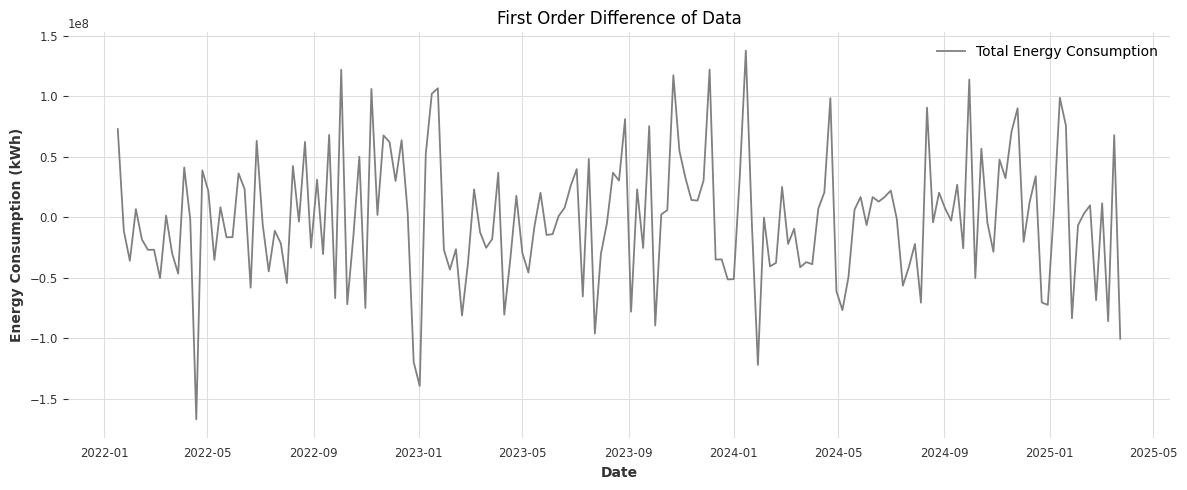

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))
first_order_diff = df['Total Energy Consumption (kWh)'].diff()
ax.plot(first_order_diff, label='Total Energy Consumption', color='gray')
ax.set_title('First Order Diﬀerence of Data')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Second Order Differencing

Formula for Second Order Diff:

D2Yt = D(D((Yt)) = D (Yt - Yt-1) = D(Yt) - D(Yt-1) = Yt - 2Yt-1 + Yt+2

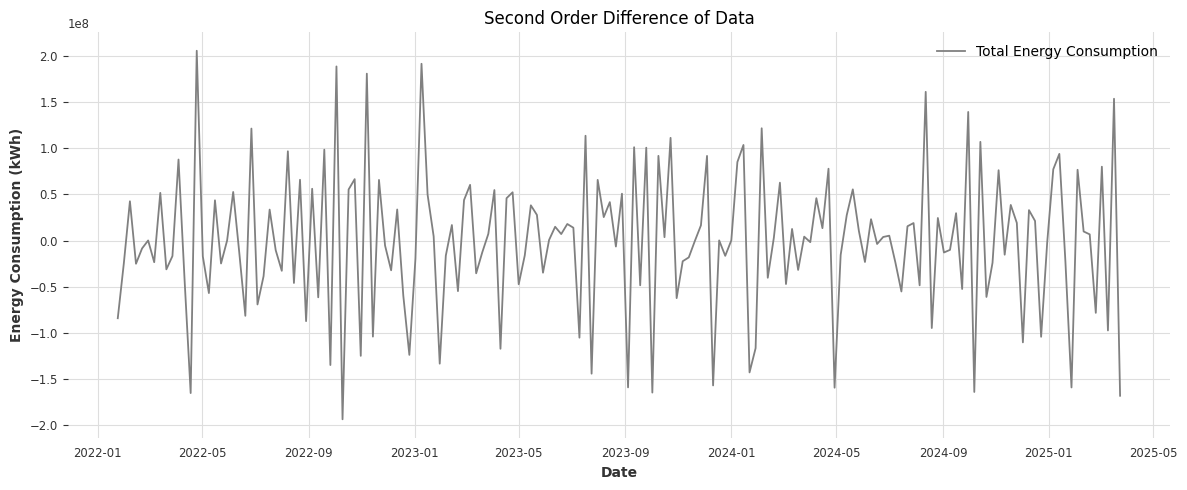

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
df_2_difference = first_order_diff.diff()
ax.plot(df_2_difference, label='Total Energy Consumption', color='gray')
ax.set_title('Second Order Diﬀerence of Data')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

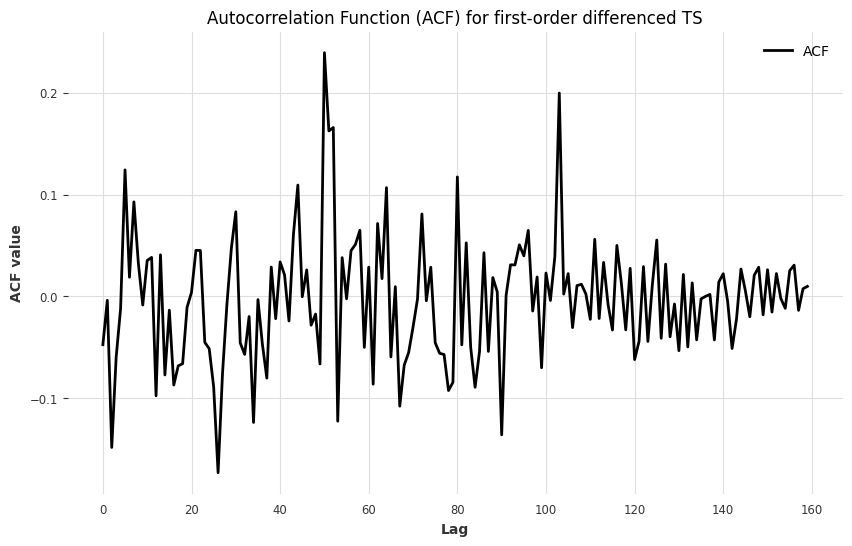

In [46]:
acf_vals_1 = check_autocorrelation(first_order_diff.dropna(), nlags=nlags)
acf_series = TimeSeries.from_values(acf_vals_1[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF) for first-order differenced TS")
plt.xlabel("Lag")
plt.ylabel("ACF value")
plt.legend(loc="upper right")
plt.show()

This suggests seasonality with a period of 5, as in 5 weeks

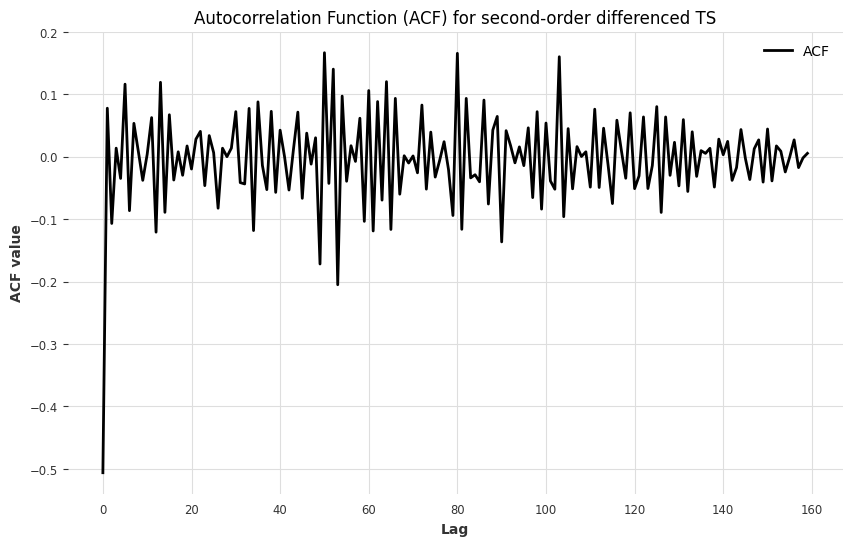

In [47]:
acf_vals_2 = check_autocorrelation(df_2_difference.dropna(), nlags=nlags)
acf_series = TimeSeries.from_values(acf_vals_2[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF) for second-order differenced TS")
plt.xlabel("Lag")
plt.ylabel("ACF value")
plt.legend(loc="upper right")
plt.show()

Detrending is not enough to make TS stationnary

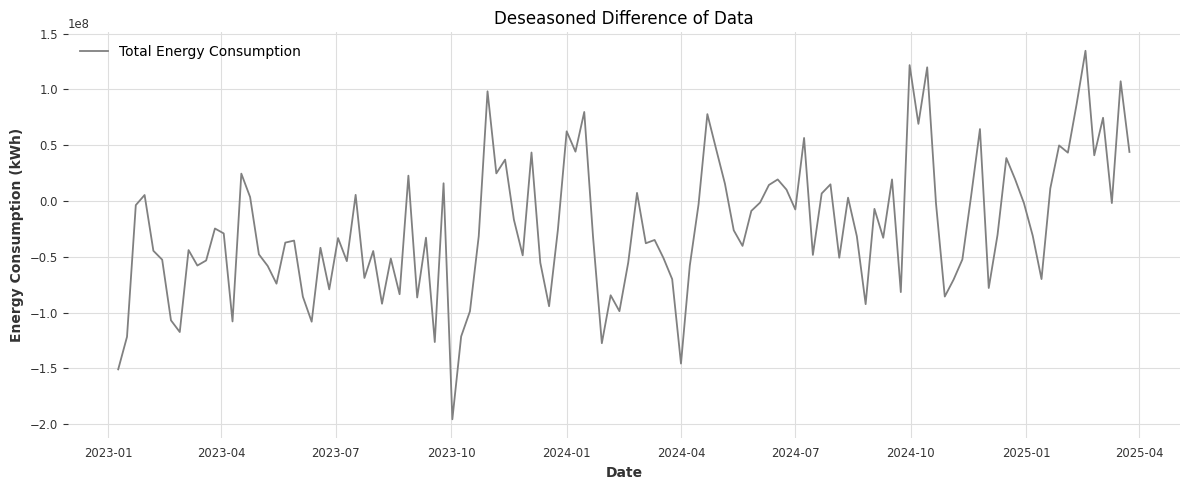

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))
deseasoned_df = df['Total Energy Consumption (kWh)'].diff(52)
ax.plot(deseasoned_df, label='Total Energy Consumption', color='gray')
ax.set_title('Deseasoned Diﬀerence of Data')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Do the deseasoning using SARMA model

In [49]:
from darts.utils.statistics import (
    remove_trend,
    stationarity_test_adf,
    stationarity_test_kpss,
    plot_acf,
    plot_pacf
)

In [50]:
seasonal_diff = df_2_difference.diff(52).dropna()
seasonal_diff_series = TimeSeries.from_values(df_2_difference.diff(52).dropna())

Text(0.5, 1.0, 'ACF of Differenced Series')

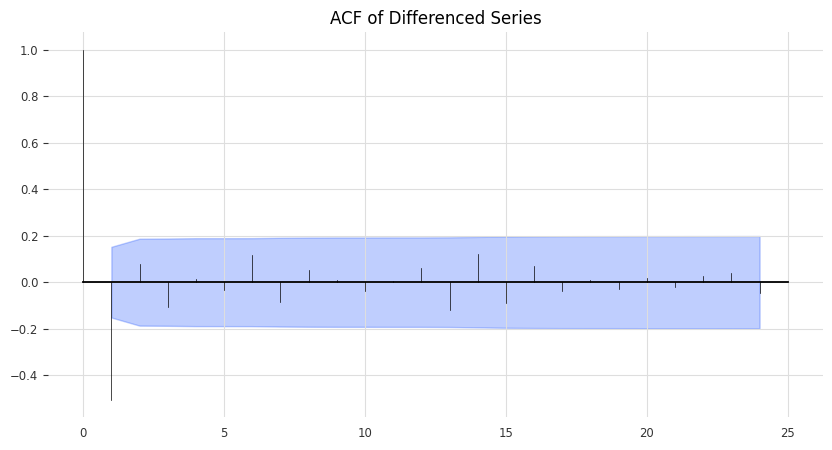

In [51]:
plot_acf(TimeSeries.from_values(df_2_difference.dropna()))
plt.title("ACF of Differenced Series")


Text(0.5, 1.0, 'ACF of Deseasoned Series')

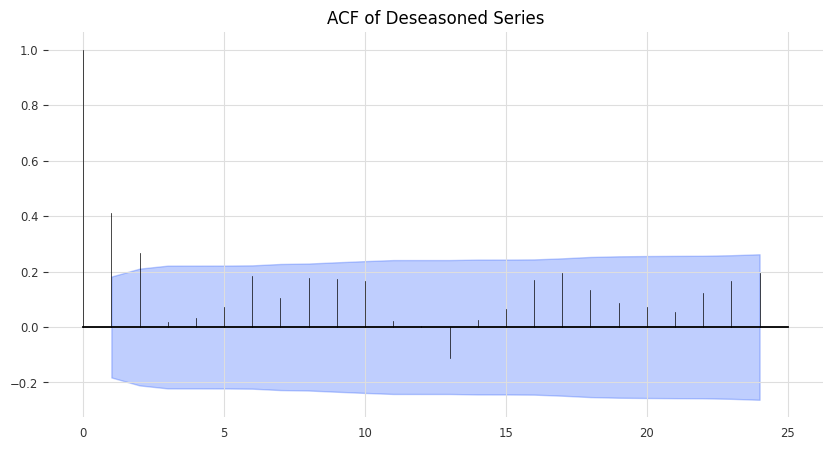

In [52]:
plot_acf(TimeSeries.from_values(deseasoned_df.dropna()))
plt.title("ACF of Deseasoned Series")

Text(0.5, 1.0, 'PACF of Deseasoned Series')

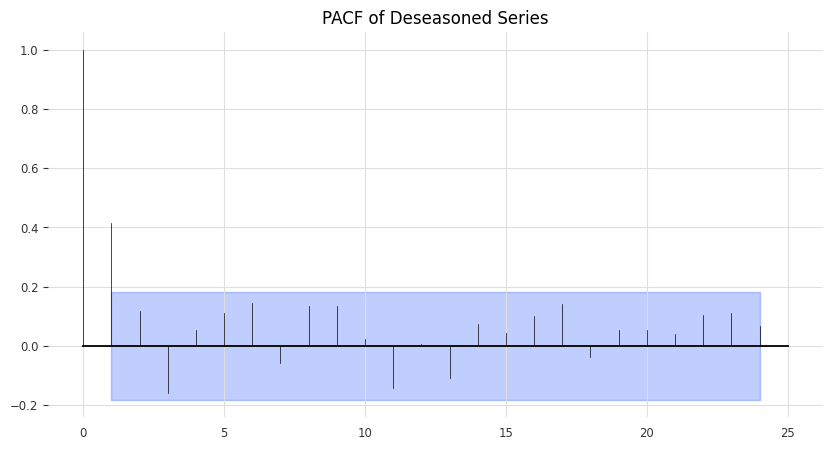

In [53]:
plot_pacf(TimeSeries.from_values(deseasoned_df.dropna()))
plt.title("PACF of Deseasoned Series")

If {Yt} is white noise, then ρh = 0 for all h. which is the case right now ...

In [54]:
pacf_phi_vector = pacf_yule_walker_full(acf_vals, nlags=nlags)

# Testing for stationnarity

In [55]:
differed_series = TimeSeries.from_values(df_2_difference.dropna())
initial_series = TimeSeries.from_values(energy_consumption_data)

In [56]:
alpha=0.1

In [57]:
is_stationary = stationarity_test_kpss(initial_series)
stat, p_value, lags, crit_vals = stationarity_test_kpss(initial_series)
print(f"KPSS statistic: {stat}")
print(f"p-value: {p_value}")
is_stationary = alpha <= p_value
print(f"Is stationary: {is_stationary}")


KPSS statistic: 0.11391747420474804
p-value: 0.1
Is stationary: True


/opt/homebrew/lib/python3.11/site-packages/darts/utils/statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
/opt/homebrew/lib/python3.11/site-packages/darts/utils/statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


In [58]:
from darts.utils.statistics import stationarity_tests

is_stationary = stationarity_tests(
    initial_series,
    p_value_threshold_kpss=0.05
)

# Print interpretation
print("Series is stationary" if is_stationary else "Series is not stationary")


Series is stationary


/opt/homebrew/lib/python3.11/site-packages/darts/utils/statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


In [59]:
from darts.utils.statistics import stationarity_tests

is_stationary = stationarity_tests(
    initial_series.diff(52),
    p_value_threshold_kpss=0.05
)

# Print interpretation
print("Series is stationary" if is_stationary else "Series is not stationary")


Series is stationary


/opt/homebrew/lib/python3.11/site-packages/darts/utils/statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


(ii) ... that is the covariance is invariant  (source: ETHZ, Time Series Analysis 2022)

# III. Testing for white noise

There are many methods to test for white noise. One of which, documented in the Time Series Analysis book, is Cumulative Periodogram.


# Periodogram 

In [60]:
def compute_linear_periodogram(y):
    y = np.asarray(y)
    n = len(y)
    m = (n - 1) // 2 if n % 2 else n // 2
    freqs = np.arange(1, m + 1) / n
    I_vals = []

    for omega in freqs:
        cos_part = np.sum(y * np.cos(2 * np.pi * omega * np.arange(1, n + 1)))
        sin_part = np.sum(y * np.sin(2 * np.pi * omega * np.arange(1, n + 1)))
        I = (1 / n) * (cos_part**2 + sin_part**2)
        I_vals.append(I)

    return freqs, np.array(I_vals)


In [61]:
valid_mask = time_index.year <= 2024
series_trimmed = energy_consumption_data
series_trimmed = energy_consumption_data[valid_mask]

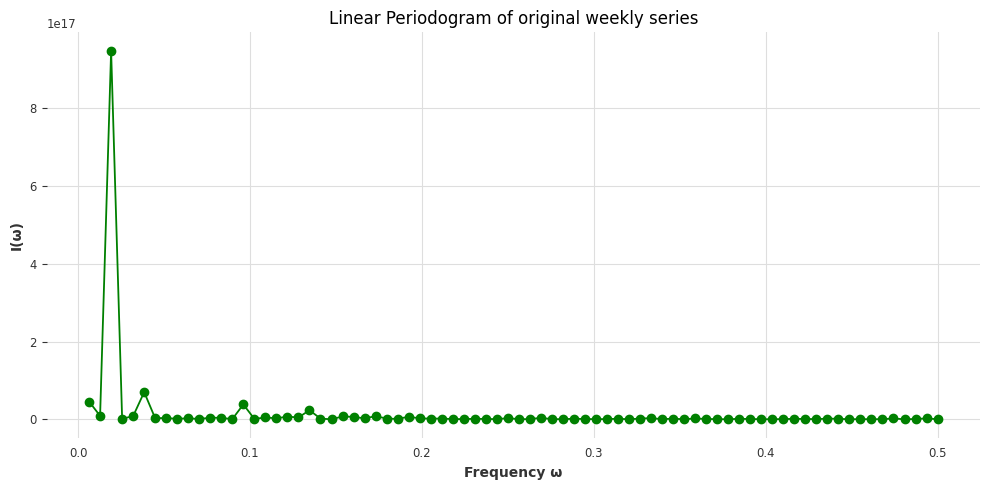

In [62]:
freqs_original, I_vals_original = compute_linear_periodogram(series_trimmed)
plt.figure(figsize=(10, 5))
plt.plot(freqs_original, I_vals_original, marker='o', color = 'g')
plt.title("Linear Periodogram of original weekly series")
plt.xlabel('Frequency ω')
plt.ylabel("I(ω)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
threshold=2*1e16

In [64]:
significant_frequencies = [(w, I) for w, I in zip(freqs_original, I_vals_original) if I > threshold]
for freq, power in significant_frequencies:
    print(f"Frequency: {freq:.5f}, Power: {power:.2e}, Period ≈ {1/freq:.2f} weeks")

Frequency: 0.00641, Power: 4.57e+16, Period ≈ 156.00 weeks
Frequency: 0.01923, Power: 9.48e+17, Period ≈ 52.00 weeks
Frequency: 0.03846, Power: 6.99e+16, Period ≈ 26.00 weeks
Frequency: 0.09615, Power: 3.82e+16, Period ≈ 10.40 weeks
Frequency: 0.13462, Power: 2.34e+16, Period ≈ 7.43 weeks


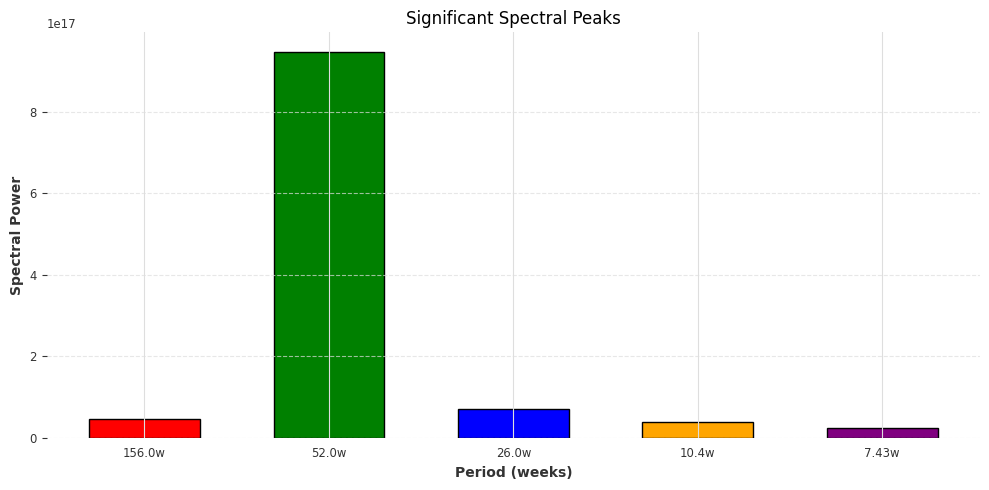

In [65]:

# Extract periods and powers
periods = [round(1 / freq, 2) for freq, _ in significant_frequencies]
powers = [power for _, power in significant_frequencies]

# Define colors for each bar
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Create the bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(periods)), powers, color=colors, edgecolor='black', width=0.6)

# Add period labels on x-axis
plt.xticks(range(len(periods)), [f"{p}w" for p in periods])

# Labeling
plt.xlabel("Period (weeks)")
plt.ylabel("Spectral Power")
plt.title("Significant Spectral Peaks")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [66]:
threshold=2*1e16
significant_frequencies = [(w, I) for w, I in zip(freqs_original, I_vals_original) if I > threshold]
for freq, power in significant_frequencies:
    print(f"Frequency: {freq:.5f}, Power: {power:.2e}, Period ≈ {1/freq:.2f} weeks")

Frequency: 0.00641, Power: 4.57e+16, Period ≈ 156.00 weeks
Frequency: 0.01923, Power: 9.48e+17, Period ≈ 52.00 weeks
Frequency: 0.03846, Power: 6.99e+16, Period ≈ 26.00 weeks
Frequency: 0.09615, Power: 3.82e+16, Period ≈ 10.40 weeks
Frequency: 0.13462, Power: 2.34e+16, Period ≈ 7.43 weeks


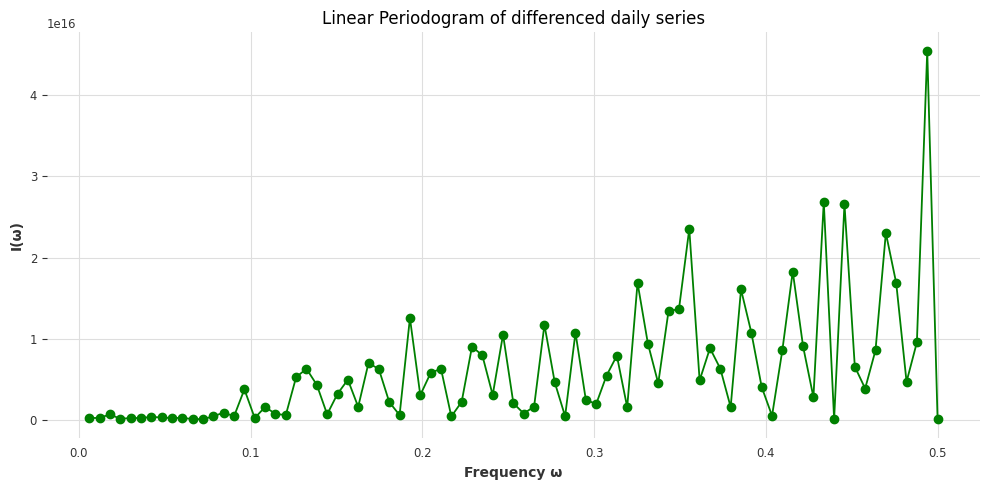

In [67]:
freqs_diff, I_vals_diff = compute_linear_periodogram(df_2_difference.dropna())
plt.figure(figsize=(10, 5))
plt.plot(freqs_diff, I_vals_diff, marker='o', color = 'g')
plt.title("Linear Periodogram of differenced daily series")
plt.xlabel('Frequency ω')
plt.ylabel("I(ω)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
threshold=2*1e16

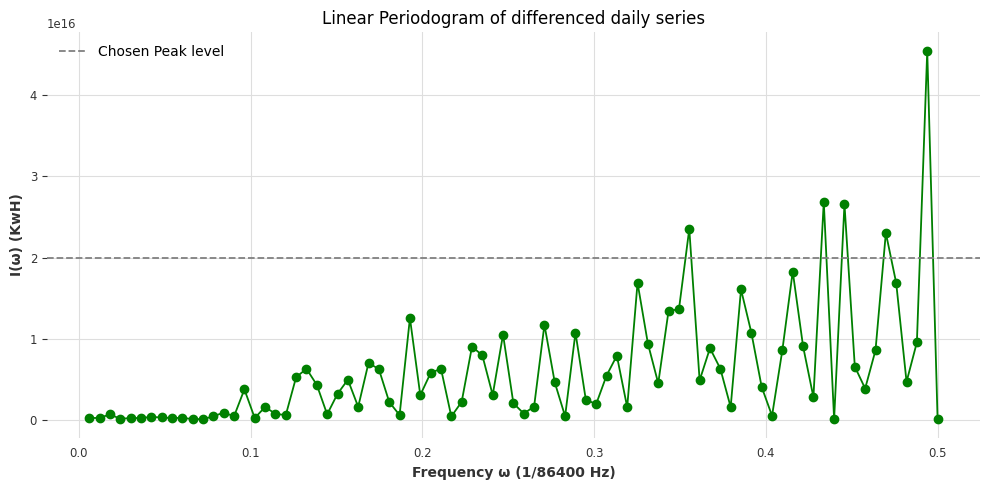

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(freqs_diff, I_vals_diff, marker='o', color = 'g')
plt.title("Linear Periodogram of differenced daily series")
plt.xlabel('Frequency ω (1/86400 Hz)')
plt.axhline(threshold, color='grey', linestyle='--', label='Chosen Peak level')
plt.ylabel("I(ω) (KwH)")
plt.grid(True)
plt.tight_layout()
plt.legend()

In [70]:
significant_differenced_frequencies = [(w, I) for w, I in zip(freqs_diff, I_vals_diff) if I > threshold]

In [71]:
for freq, power in significant_differenced_frequencies:
    print(f"Frequency: {freq:.5f}, Power: {power:.2e}, Period ≈ {1/freq:.2f} weeks")

Frequency: 0.35542, Power: 2.35e+16, Period ≈ 2.81 weeks
Frequency: 0.43373, Power: 2.69e+16, Period ≈ 2.31 weeks
Frequency: 0.44578, Power: 2.66e+16, Period ≈ 2.24 weeks
Frequency: 0.46988, Power: 2.30e+16, Period ≈ 2.13 weeks
Frequency: 0.49398, Power: 4.55e+16, Period ≈ 2.02 weeks


Plotting one of the Fourrier Series

In [72]:
from matplotlib.cm import get_cmap


Plotting sine waves in separate subplots with different colors.

In [73]:
def plot_significant_waves(significant_freqs, duration=30, sampling_rate=100):
    t = np.linspace(0, duration, duration * sampling_rate)
    n = len(significant_freqs)
    cmap = get_cmap('tab10')

    max_amplitude = max(power for _, power in significant_freqs)

    fig, axs = plt.subplots(n, 1, figsize=(11, 1.5 * n), sharex=True)
    if n == 1:
        axs = [axs]

    for i, (freq, power) in enumerate(significant_freqs):
        amplitude = power
        y = amplitude * np.sin(2 * np.pi * freq * t)
        color = cmap(i % cmap.N)
        axs[i].plot(t, y, color=color)
        axs[i].set_ylim(-max_amplitude * 1.1, max_amplitude * 1.1)
        axs[i].set_title(f'ω = {freq:.3f}, T ≈ {1/freq:.2f} days, Power = {power:.2e}', fontsize=10)
        axs[i].set_ylabel('Amplitude')
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (weeks)')
    plt.tight_layout()
    fig.suptitle("Decomposed High Signals of Differenced Daily Series (threshold= 2.7*1e16) ", fontsize=14, y=1.02)
    plt.show()


In [74]:
threshold= 0.7*1e16

/var/folders/t4/tvh60p3s6t1g30sq60618qpw0000gn/T/ipykernel_57218/1304845531.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


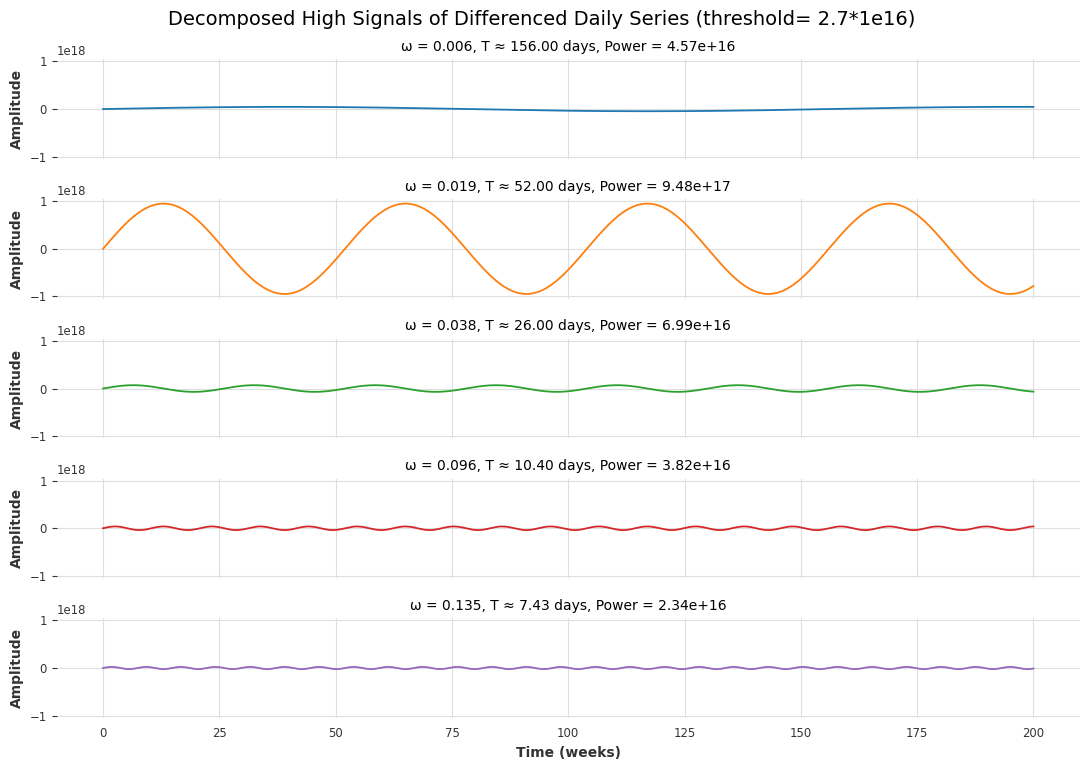

In [75]:
plot_significant_waves(significant_frequencies, duration=200, sampling_rate=300)

In [76]:
def reconstruct_signal_from_spectrum_on_index(significant_freqs, time_index):
    t = np.arange(len(time_index))
    reconstructed_signal = np.zeros_like(t, dtype=float)

    for freq, power in significant_freqs:
        amplitude = np.sqrt(power)  # power to amplitude
        reconstructed_signal += amplitude * np.sin(2 * np.pi * freq * t)  

    return time_index, reconstructed_signal

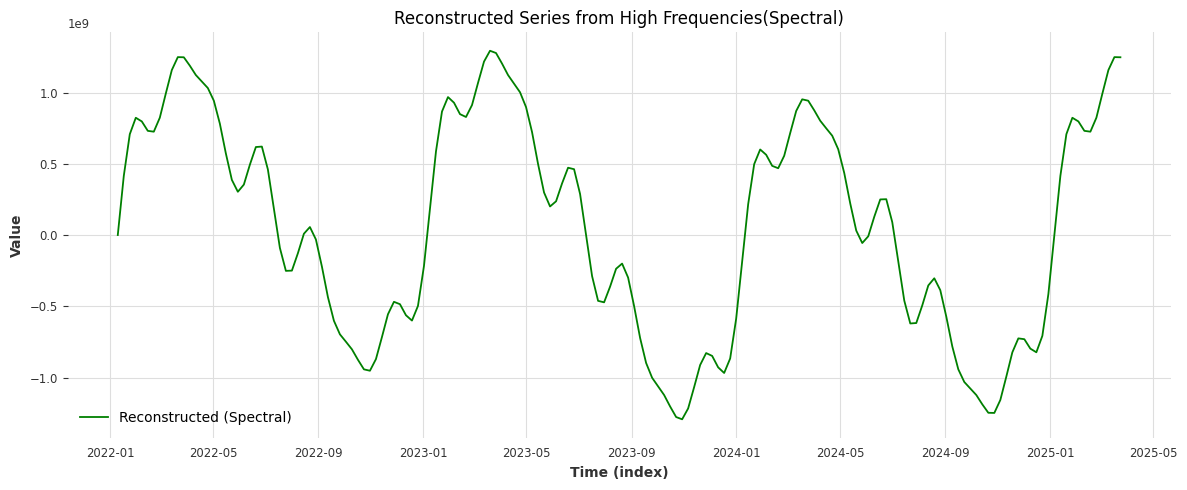

In [77]:

t_index, recon = reconstruct_signal_from_spectrum_on_index(significant_frequencies, time_index)

plt.figure(figsize=(12, 5))
plt.plot(t_index, recon, label='Reconstructed (Spectral)', color = 'g')
plt.title("Reconstructed Series from High Frequencies(Spectral)")
plt.xlabel("Time (index)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


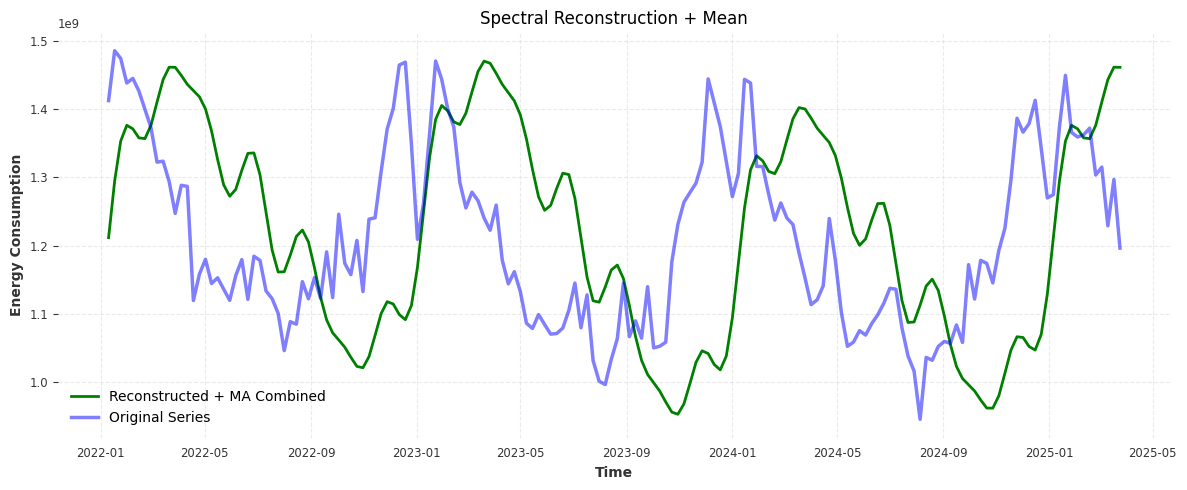

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Reconstruct signal from spectral components ---
t_index, recon = reconstruct_signal_from_spectrum_on_index(significant_frequencies, time_index)

# --- Step 2: Apply Moving Average (chosen not to) ---
window = 3 
recon_ma = np.convolve(recon, np.ones(window)/window, mode='same')

# --- Step 3: Combine spectral reconstruction and moving average ---
# Adjust weights if needed to balance detail vs smoothness
combined_signal = 0.2 * recon

# --- Step 4: Add back the original mean just once (after combining) ---
signal_mean = np.mean(energy_consumption_data)
combined_signal += signal_mean

# --- Step 5: Plot ---
plt.figure(figsize=(12, 5))

plt.plot(t_index, combined_signal, label='Reconstructed + MA Combined', color='green', linewidth=2)
plt.plot(time_index[:len(energy_consumption_data)], energy_consumption_data,
         label='Original Series', linewidth=2.5, color='blue', alpha=0.5)

plt.title("Spectral Reconstruction + Mean")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [79]:
def plot_cumulative_periodogram(freqs, I_vals, show_plot=True, threshold=0.1):
    freqs = np.array(freqs)
    I_vals = np.array(I_vals)

    # Sort by frequency
    sorted_idx = np.argsort(freqs)
    freqs = freqs[sorted_idx]
    I_vals = I_vals[sorted_idx]

    # Keep only non-negative frequencies
    mask = freqs >= 0
    freqs = freqs[mask]
    I_vals = I_vals[mask]

    # Normalize and compute cumulative
    total_power = np.sum(I_vals)
    cumulative_power = np.cumsum(I_vals)
    C = cumulative_power / total_power

    # Expected under white noise: linear
    expected = np.linspace(0, 1, len(C))
    max_deviation = np.max(np.abs(C - expected))
    percent_error = max_deviation * 100
    is_white_noise = percent_error <= threshold * 100

    if show_plot:
        plt.figure(figsize=(10, 5))
        plt.step(freqs, C, where='post', label="Cumulative Periodogram", color='blue', lw=2)
        plt.plot([freqs[0], freqs[-1]], [0, 1], 'r--', label="KS Line: $y = x$")
        plt.xlabel("Frequency ω (1/week)")
        plt.ylabel("Cumulative Proportion of Power")
        plt.title("Cumulative Periodogram vs Flat Spectrum")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(0, 1.05)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"Maximum deviation from uniform: {percent_error:.2f}%")
        print("Conclusion:", "Likely white noise" if is_white_noise else "Not white noise")

    return freqs, C



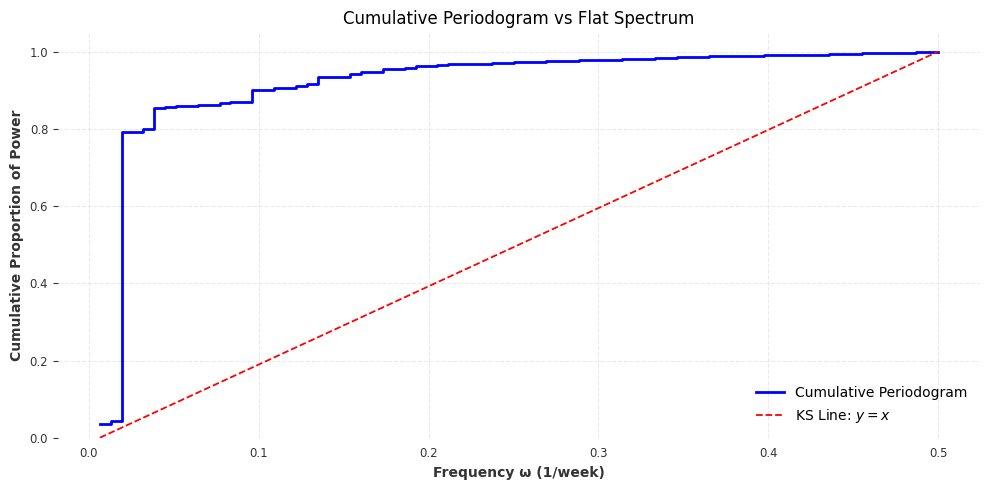

Maximum deviation from uniform: 78.97%
Conclusion: Not white noise


In [80]:
freqs_sorted, C_vals = plot_cumulative_periodogram(freqs_original, I_vals_original)

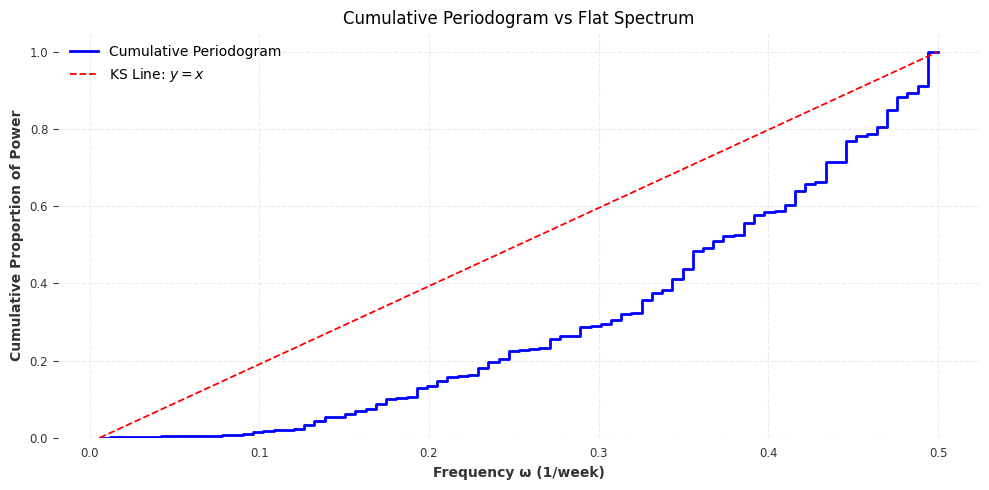

Maximum deviation from uniform: 31.06%
Conclusion: Not white noise


In [81]:
freqs_sorted, C_vals = plot_cumulative_periodogram(freqs_diff, I_vals_diff)

Max deviation (KS statistic): 3.61%


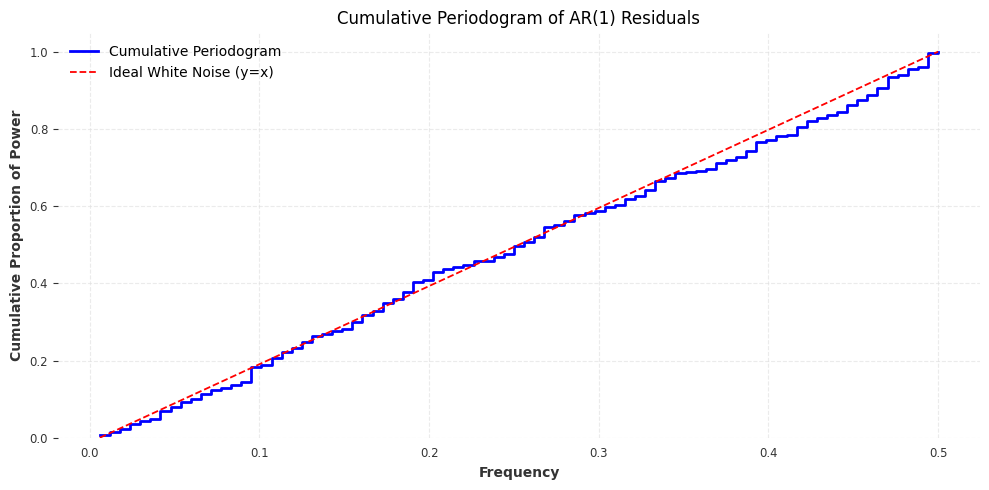

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Step 1: Fit SARIMA model ---
model = SARIMAX(energy_consumption_data, order=(1, 0, 0))
results = model.fit()

# --- Step 2: Get residuals ---
residuals = results.resid

# --- Step 3: Compute periodogram ---
freqs, power = periodogram(residuals)

# Keep only positive frequencies
mask = freqs > 0
freqs = freqs[mask]
power = power[mask]

# --- Step 4: Compute cumulative periodogram ---
cumulative_power = np.cumsum(power) / np.sum(power)
expected = np.linspace(0, 1, len(cumulative_power))

# --- Step 5: Kolmogorov-Smirnov (KS) test statistic ---
ks_stat = np.max(np.abs(cumulative_power - expected))
print(f"Max deviation (KS statistic): {ks_stat*100:.2f}%")

# --- Step 6: Plot cumulative periodogram ---
plt.figure(figsize=(10, 5))
plt.step(freqs, cumulative_power, where='post', label="Cumulative Periodogram", color='blue', lw=2)
plt.plot([freqs[0], freqs[-1]], [0, 1], 'r--', label="Ideal White Noise (y=x)")
plt.xlabel("Frequency")
plt.ylabel("Cumulative Proportion of Power")
plt.title("Cumulative Periodogram of AR(1) Residuals")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


168
Max deviation (KS statistic): 12.11%


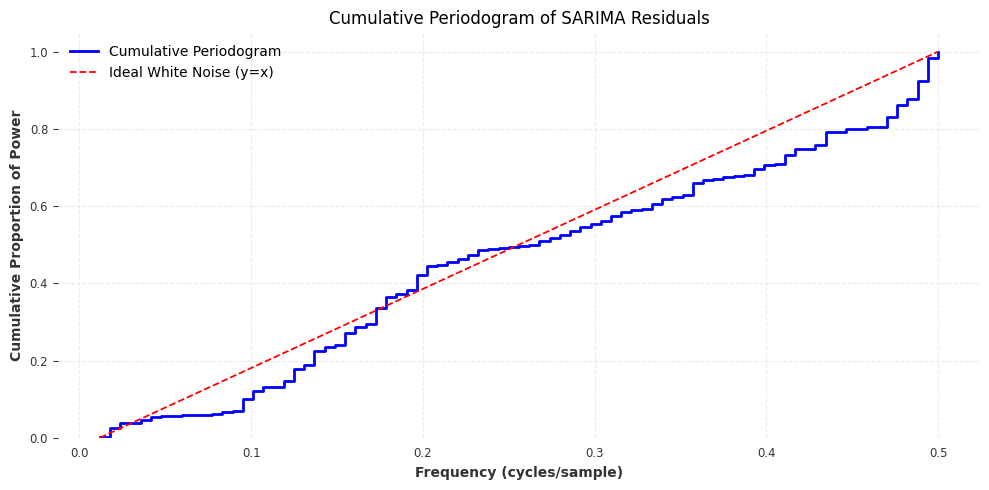

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Fit model ---
model = SARIMAX(energy_consumption_data, order=(1, 0, 0), seasonal_order=(1, 0, 0, 52))
results = model.fit()
print(len(residuals))
# --- Get residuals and drop NaNs ---
residuals = results.resid

# --- Sanity check for enough data ---
if len(residuals) < 60:
    raise ValueError("Too few residuals for reliable cumulative periodogram (need ≥ 60).")

# --- Periodogram with Hann window ---
freqs, power = periodogram(residuals, window='hann')

# --- Remove near-zero frequencies (very low cycles per sample) ---
min_freq = 1 / len(residuals)
mask = freqs > min_freq
freqs = freqs[mask]
power = power[mask]

# --- Cumulative periodogram ---
cumulative_power = np.cumsum(power) / np.sum(power)
expected = np.linspace(0, 1, len(cumulative_power))

# --- KS statistic ---
ks_stat = np.max(np.abs(cumulative_power - expected))
print(f"Max deviation (KS statistic): {ks_stat*100:.2f}%")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.step(freqs, cumulative_power, where='post', label="Cumulative Periodogram", color='blue', lw=2)
plt.plot([freqs[0], freqs[-1]], [0, 1], 'r--', label="Ideal White Noise (y=x)")
plt.xlabel("Frequency (cycles/sample)")
plt.ylabel("Cumulative Proportion of Power")
plt.title("Cumulative Periodogram of SARIMA Residuals")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1200x400 with 0 Axes>

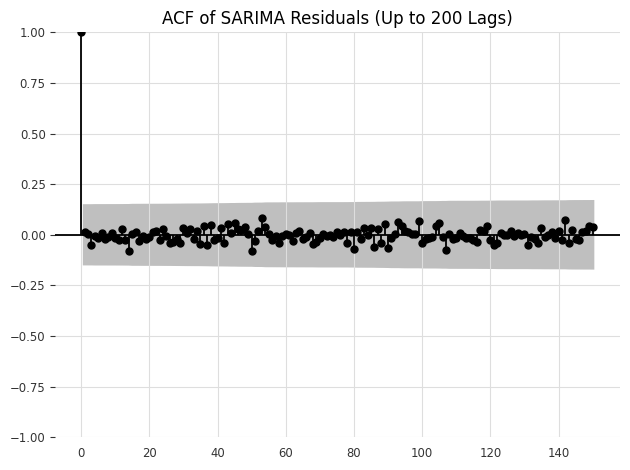

In [84]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# residuals already cleaned: residuals = results.resid.dropna()

plt.figure(figsize=(12, 4))
plot_acf(residuals, lags=150, alpha=0.05)
plt.title("ACF of SARIMA Residuals (Up to 200 Lags)")
plt.tight_layout()
plt.show()


interpret ACF of SARIMA Residuals

In [85]:
print(results)

# Smoothing

# Local Polynomial Regression

In [86]:
frac = 0.1

**III. 1.a. Formal check**

expliquez comment seasonality marche, comment trending marche, pourquoi on n'a pas utilité IGD, 

In [87]:
time_series = TimeSeries.from_values(energy_consumption_data)

Extracting Trend and Seasonality

I'm going to use a DARTS function

method (str) – The method to be used to decompose the series. - “naive” : Seasonal decomposition using moving averages [1]. - “STL” : Season-Trend decomposition using LOESS [2]. Only compatible with ADDITIVE model type. - “MSTL” : Season-Trend decomposition using LOESS with multiple seasonalities [3]. Only compatible with ADDITIVE model type.


comprendre les deux

Check si il y a plusieurs fréquences, lequels, c'est quoi leurs amplitudes, check residual stat

# Forecasting Models

In [88]:
from darts.models import ARIMA
from darts.metrics import mape

/opt/homebrew/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


## AR 1

AR1 8-week horizon

In [89]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 8 weeks) ---
model = ARIMA(1, 0, 0)
horizon = 8
start = len(series) - 52 - horizon + 1

forecast = model.historical_forecasts(
    series=series,
    start=start,
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True,
    show_warnings=False  # Optional: suppress warning messages
)
# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (AR(1,0,0), 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="AR(1,0,0) Rolling Forecast (8-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/AR_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")



MAPE (Weekly, 8-week Horizon): 8.39%


## ARMA

ARMA 8-week horizon

In [90]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings
from functools import reduce

warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Training and prediction settings ---
horizon = 8                    # forecast 12 steps ahead
train_len = 104                # 2 years of training
start_idx = len(series) - 52  # last 1 year

# --- Containers for predicted and actual values ---
predicted = []
actual_vals = []

# --- Initialize model ---
model = ARIMA(1, 0, 1)  # ARIMA(1,0,0) with yearly seasonality
horizon = 8            
start = len(series) - 52 - horizon + 1

forecast = model.historical_forecasts(
    series=series,
    start=start,
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True,
    show_warnings=False  # Optional: suppress warning messages
)
# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# --- Plot ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name=' Autoregressive Moving Average Model (1,0,1)',
    line=dict(color='red')
))

fig.update_layout(
    title="Autoregressive Moving Average Model (1,0,1), 8-Week Horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

fig.show()

# --- Save ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/ARMA_data.json",
    pretty=True
)

# --- MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (Student Forcing, Weekly): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")


MAPE (Student Forcing, Weekly): 8.48%


## ARIMA

In [91]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

model = ARIMA(1, 1, 0)  # ARIMA(1,1,0) with yearly seasonality
horizon = 8            
start = len(series) - 52 - horizon + 1

forecast = model.historical_forecasts(
    series=series,
    start=start,
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True,
    show_warnings=False  # Optional: suppress warning messages
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Autoregressive Integrated Moving Average Model(1,1,0), 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="Autoregressive Integrated Moving Average Model(1,1,0), 8-week horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/ARIMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/arima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")


MAPE (Weekly, 8-week Horizon): 8.42%


## SARIMA

8 week horizon

In [92]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)
#model = SARIMAX(energy_consumption_data, order=(2, 1, 0), seasonal_order=(1, 1, 1, 52))
# --- Fit ARIMA and Multi-Step Forecast (Horizon = 8 weeks) ---
model = ARIMA(1, 0, 0, seasonal_order=(1,0,0,52))  # ARIMA(1,0,1) with yearly seasonality
horizon = 8             # forecast 8 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Seasonal Autoregressive Integrated Moving Average(1,0,0), (1,0,0)[52]-52-week seasonality, 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="Seasonal Autoregressive Integrated Moving Average(1,0,0), (1,0,0)[52]-52-week seasonality, 8-week horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/SARIMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"\u2705 MAPE (Weekly, 12-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/sarima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("\u26A0\ufe0f Forecast and actual series do not match in length.")


✅ MAPE (Weekly, 12-week Horizon): 6.60%


## SARIMAX

In [93]:
%pip install cdsapi -q

Note: you may need to restart the kernel to use updated packages.


In [94]:
df = df_backup

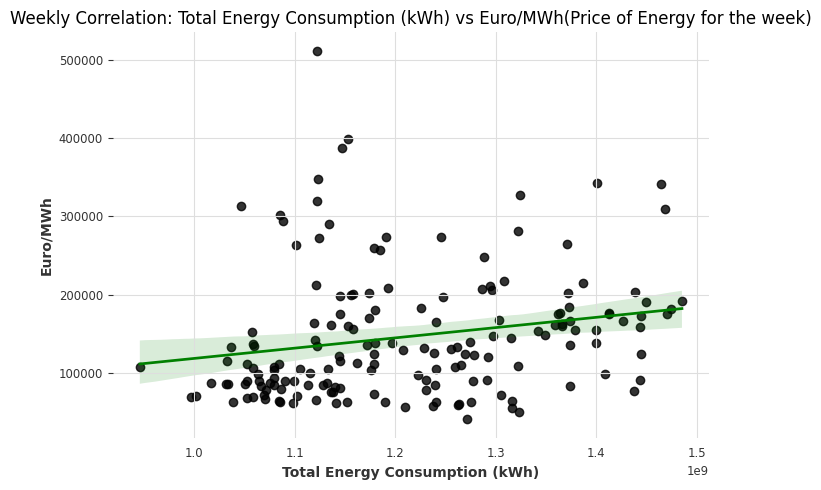

Pearson correlation: 0.2082


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

x_col = "Total Energy Consumption (kWh)"
y_col = "Euro/MWh"

# Align on weekly frequency and drop missing values
df_weekly = df[[x_col, y_col]].dropna()

# Plot
plt.figure(figsize=(7, 5))
sns.regplot(data=df_weekly, x=x_col, y=y_col, line_kws={"color": "green"})
plt.title(f"Weekly Correlation: {x_col} vs {y_col}(Price of Energy for the week)")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
correlation = df_weekly.corr().loc[y_col, x_col]
print(f"Pearson correlation: {correlation:.4f}")


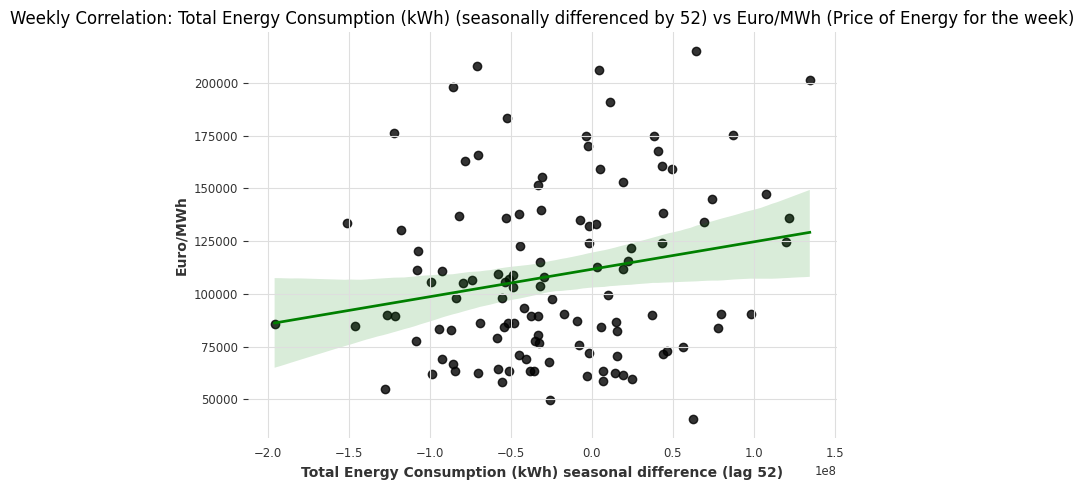

Pearson correlation: 0.2011


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

x_col = "Total Energy Consumption (kWh)"
y_col = "Euro/MWh"

# Compute seasonal difference by lag 52 (1 year)
df[f"{x_col}_diff52"] = df[x_col] - df[x_col].shift(52)

# Drop NaN rows after differencing and drop missing values in y_col
df_weekly = df[[f"{x_col}_diff52", y_col]].dropna()

# Plot
plt.figure(figsize=(7, 5))
sns.regplot(data=df_weekly, x=f"{x_col}_diff52", y=y_col, line_kws={"color": "green"})
plt.title(f"Weekly Correlation: {x_col} (seasonally differenced by 52) vs {y_col} (Price of Energy for the week)")
plt.xlabel(f"{x_col} seasonal difference (lag 52)")
plt.ylabel(y_col)
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
correlation = df_weekly.corr().loc[y_col, f"{x_col}_diff52"]
print(f"Pearson correlation: {correlation:.4f}")


In [97]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings
# Step 1: Clean alignment between energy and temperature series
weekly_temp_anomaly = weekly_temp_anomaly.dropna()
temperature_series = weekly_temp_anomaly

min_len = min(len(time_index), len(energy_consumption_data), len(temperature_series))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]
temperature_series = temperature_series[:min_len]

# Step 2: Create TimeSeries objects
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

temperature_series.index = pd.DatetimeIndex(temperature_series.index)
temp_cov = TimeSeries.from_series(temperature_series)

# Step 3: Align series
series = series.slice_intersect(temp_cov)
temp_cov = temp_cov.slice_intersect(series)

# Step 4: Model training and forecasting
warnings.filterwarnings("ignore")
model = ARIMA(1, 0, 0, seasonal_order=(1, 0, 0, 52))
horizon = 8

forecast = model.historical_forecasts(
    series=series,
    future_covariates=temp_cov,
    start=len(series) - 52,
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True
)

# Step 5: Plotting
actual = series.slice(forecast.start_time(), forecast.end_time())
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_df.index, y=actual_df["Actual"],
                         mode='lines+markers', name='Actual Weekly',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df["Forecast"],
                         mode='lines+markers', name='SARIMA Forecast (with Temp)',
                         line=dict(color='red')))

fig.update_layout(
    title="SARIMA(1,0,0) + Temperature as Future Covariate",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)
fig.show()

# Save JSON
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMAX/SARIMAX_data.json",
    pretty=True
)

# Save MAPE
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")
    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMAX/sarimax_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")


`start` position `63` corresponding to time `2023-03-27 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2024-01-08 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.


✅ MAPE (Weekly, 8-week Horizon): 3.20%


# Evaluation

In [98]:
from darts.metrics import mape

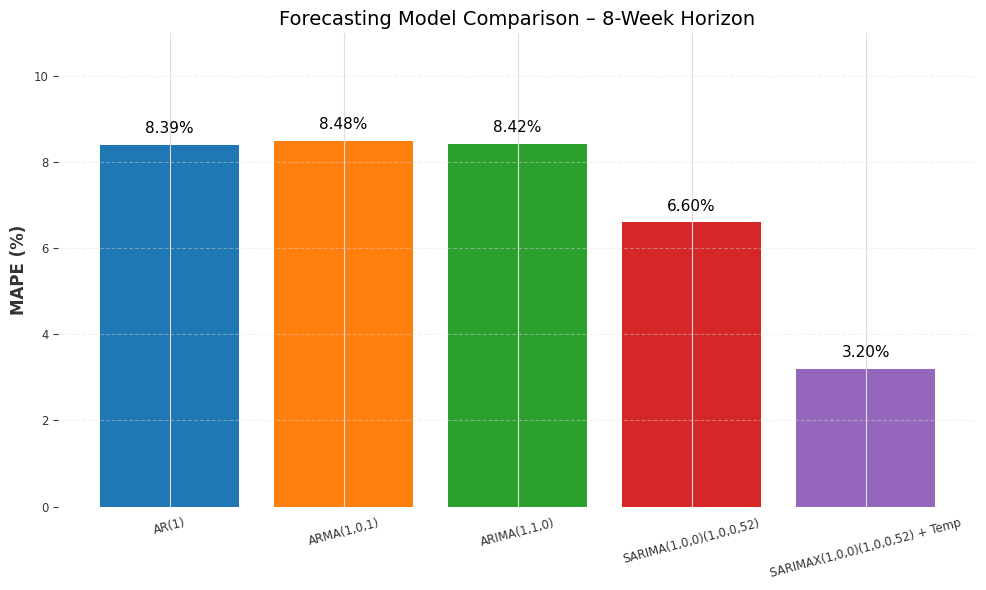

In [99]:
# Define models in desired order
models = {
    "AR(1)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt",
    "ARMA(1,0,1)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt",
    "ARIMA(1,1,0)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/arima_mape.txt",
    "SARIMA(1,0,0)(1,0,0,52)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/sarima_mape.txt",
    "SARIMAX(1,0,0)(1,0,0,52) + Temp": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMAX/sarimax_mape.txt",
}

# Read MAPE values
mape_scores = {}
for model_name, path in models.items():
    try:
        with open(path, "r") as f:
            mape_scores[model_name] = float(f.read().strip())
    except Exception as e:
        mape_scores[model_name] = None
        print(f"⚠️ Could not read MAPE for {model_name}: {e}")

# Filter out any models with missing values
mape_scores = {k: v for k, v in mape_scores.items() if v is not None}

# Create DataFrame in order
df = pd.DataFrame({
    "Model": list(mape_scores.keys()),
    "MAPE": list(mape_scores.values())
})

# Plot settings
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(10, 6))
bars = plt.bar(df["Model"], df["MAPE"], color=colors[:len(df)])

# Annotate bars with MAPE %
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=11)

plt.ylabel("MAPE (%)", fontsize=12)
plt.title("Forecasting Model Comparison – 8-Week Horizon", fontsize=14)
plt.xticks(rotation=15)
plt.ylim(0, max(df["MAPE"]) + 2.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
